# predict

### setup

In [1]:
#configure for local mimic databse
exec(open("../configs/configure_mimic.py").read())
exec(open("my_functions.py").read())

#Global vars
CV=4


Configured for local MIMIC database:
	user = postgres
	dbname = mimic
	host = localhost
	schema_name = mimiciii
	query_schema = SET search_path to mimiciii;


## load sets

In [2]:
import joblib
X_train = joblib.load(open('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/X_train.joblib', 'rb'))
y_train = joblib.load(open('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/y_train.joblib', 'rb'))
X_test = joblib.load(open('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/X_test.joblib', 'rb'))
y_test = joblib.load(open('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/y_test.joblib', 'rb'))

### train logistic regression with cross validation for regularization

In [ ]:
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
log_reg = LogisticRegressionCV(max_iter=1000,
#                                solver='liblinear',
                                 scoring='recall',
                               n_jobs=4)

#train
log_reg.fit(X_train, y_train)

### logistic regression cross validation performance

In [ ]:
#logistic regression cross validation
probs_log_cv = cross_val_predict(log_reg, X_train, y_train, cv=CV, method="predict_proba", n_jobs=3)
scores_log_cv = probs_log_cv[:, 1]
log_perf_cv = get_model_performance('logistic regression CV', X_train, scores_log_cv, y_train, pos_label=1)

In [ ]:
#performance on the test set
probs_test = log_reg.predict_proba(X_test)
scores_test = probs_test[:, 1]
test_perf = get_model_performance('logistic regression test set', X_test, scores_test, y_test, pos_label=1)

In [ ]:
print(log_perf_cv['auc'])

## Random forest

In [ ]:
#------- OPTIMIZE RF
RAND_SEED=321
N_JOBS=1
#use RandomizedSearchCV() to optimized Random forest hyperparameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rf_clf = RandomForestClassifier()

#choose parameter grid values
max_depth = [10, 20, 30, 40, 50]
min_samples_split = [2]
min_samples_leaf = [1]

#make grid dict
random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


# ### run random search
rf_search = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               scoring = 'precision',
                               cv = 4,
                               verbose=2,
                               random_state=RAND_SEED,
                               n_jobs = N_JOBS)
rf_search.fit(X_train, y_train)
best_params = rf_search.best_params_
print(rf_search.best_params_)


In [ ]:
#best_params = {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40}

In [ ]:
#set up optimized rf model based on from best_params above
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
print(best_params)
rf_opt = RandomForestClassifier(n_jobs=N_JOBS,
                                min_samples_split = best_params['min_samples_split'],
                                min_samples_leaf = best_params['min_samples_leaf'],
                                max_depth = best_params['max_depth'],
                                bootstrap = True,
                               random_state=RAND_SEED)

#train
rf_opt.fit(X_train, y_train)

In [ ]:
#optimized model performance on training set
scores_opt = rf_opt.predict_proba(X_train)[:, 1]
opt_perf = get_model_performance('optimized random forest training', X_train, scores_opt, y_train, pos_label=1)

### random forest cross validation performance

In [ ]:
#logistic regression cross validation
probs_rf_cv = cross_val_predict(rf_opt, X_train, y_train, cv=CV, method="predict_proba", n_jobs=3)
scores_rf_cv = probs_rf_cv[:, 1]
rf_perf_cv = get_model_performance('logistic regression CV', X_train, scores_rf_cv, y_train, pos_label=1)
print(rf_perf_cv['auc'])

### plot AUC from the two cross validations

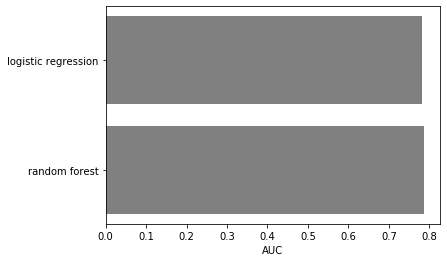

In [12]:
mods = ['logistic regression',
       'random forest']
performance = [log_perf_cv['auc'],
               rf_perf_cv['auc']]
fig, ax = plt.subplots()
y_pos = np.arange(len(mods))
ax.barh(y_pos, performance, align='center', color='grey')
ax.set_yticks(y_pos)
ax.set_yticklabels(mods)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('AUC')
plt.show()
auc_df = pd.DataFrame({'model':mods, 'auc':performance})
auc_df.to_csv('../data/for_plotting/auc_comparison.csv', index=False)

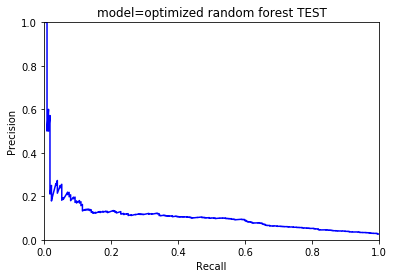

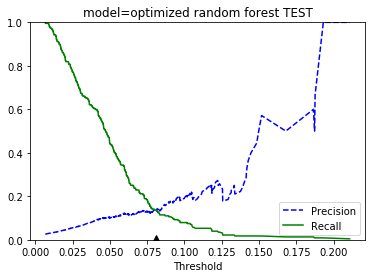

Confusion matrix for threshold = 0.08:
[[8370  195]
 [ 196   31]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8565
           1       0.14      0.14      0.14       227

    accuracy                           0.96      8792
   macro avg       0.56      0.56      0.56      8792
weighted avg       0.96      0.96      0.96      8792



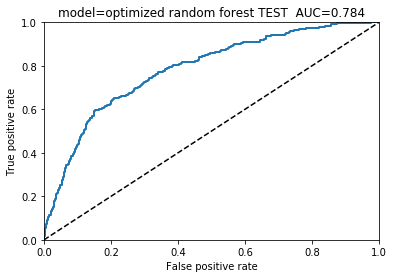

Confusion matrix for threshold = 0.04:
[[7148 1417]
 [  90  137]]
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      8565
           1       0.09      0.60      0.15       227

    accuracy                           0.83      8792
   macro avg       0.54      0.72      0.53      8792
weighted avg       0.96      0.83      0.89      8792



In [13]:
#predict for test set
test_scores = rf_opt.predict_proba(X_test)[:, 1]
test_perf = get_model_performance('optimized random forest TEST', X_test, test_scores, y_test, pos_label=1)


threshold = 0.04
opt_pred = (test_scores > threshold).astype('int')
y_num = (y_test==1).astype('int')
print('Confusion matrix for threshold = {}:'.format(round(threshold, 2)))
cm = confusion_matrix(y_num, opt_pred)
print(cm)
print('Classification report:')
print(classification_report(y_num, opt_pred))